# State Variable Filter {#sec-state-variable}
<!--
## Abstract {.unnumbered}
This notebook analyzes a [state variable filter](https://en.wikipedia.org/wiki/State_variable_filter) by solving the network equations in symbolic form. The filter uses three OpAmps, seven resistors and two capacitors.
-->

## Introduction
A state variable filter using opamps was first described by @Tow1968. The filter shown in the schematic below has low pass (LP), high pass (HP) and band pass (BP) outputs. For certain combinations of resistors and capacitors, the natural frequency and Q of filter can be independently determined. All the element values are assigned a value of 1, since they will be assigned as part of the filter design process. 

![State variable filter](state_variable_filter.png){#fig-state_variable_filter}

## Circuit description
The circuit in @fig-state_variable_filter has 10 branches and eight nodes. There are two capacitors, seven resistors in the circuit and three Op Amps. The circuit has a low pass, a high pass and band pass outputs. 

## Circuit analysis
The circuit was drawn using LTSpice and the netlist was pasted into the code. Network equations were generated using the smna() function and a symbolic solution for the equations was obtained. The characteristic equation was obtained and coeficients of the equation were extracted so that the symbols could be equated to parameters known as Q and damping ratio. These were symplified by by letting R = R1 = R3 = R4 = R5 = R6 = R7 and C = C1 = C2. By letting C = 0.1$\mu$F, R was solved for to get a natural frequency of 1kHz. R2 was then solved for to get a Q of 3. Substituting component values into the equations, the filter was analyzed to obtain frequency and phase plots, impulse and step response and group delay. 

The net list for the filter is:
```
R3 3 1 1
R6 6 4 1
R7 8 7 1
R5 4 3 1
R2 7 5 1
C1 7 6 1
C2 2 8 1
O1 3 5 4 
O2 6 0 7 
V1 1 0 1
O3 8 0 2 
R1 5 0 1
R4 2 3 1
```

The following Python modules are used.

In [1]:
import os
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

## Load the net list

In [2]:
net_list = '''
R3 3 1 1
R6 6 4 1
R7 8 7 1
R5 4 3 1
R2 7 5 1
C1 7 6 1
C2 2 8 1
O1 3 5 4 
O2 6 0 7 
V1 1 0 1
O3 8 0 2 
R1 5 0 1
R4 2 3 1
'''

## Call the symbolic modified nodal analysis function

In [3]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Display the equations

In [4]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$I_{V1} + \frac{v_{1}}{R_{3}} - \frac{v_{3}}{R_{3}} = 0$<br>$- C_{2} s v_{8} + I_{O3} + v_{2} \left(C_{2} s + \frac{1}{R_{4}}\right) - \frac{v_{3}}{R_{4}} = 0$<br>$v_{3} \cdot \left(\frac{1}{R_{5}} + \frac{1}{R_{4}} + \frac{1}{R_{3}}\right) - \frac{v_{4}}{R_{5}} - \frac{v_{2}}{R_{4}} - \frac{v_{1}}{R_{3}} = 0$<br>$I_{O1} + v_{4} \cdot \left(\frac{1}{R_{6}} + \frac{1}{R_{5}}\right) - \frac{v_{6}}{R_{6}} - \frac{v_{3}}{R_{5}} = 0$<br>$v_{5} \cdot \left(\frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{7}}{R_{2}} = 0$<br>$- C_{1} s v_{7} + v_{6} \left(C_{1} s + \frac{1}{R_{6}}\right) - \frac{v_{4}}{R_{6}} = 0$<br>$- C_{1} s v_{6} + I_{O2} + v_{7} \left(C_{1} s + \frac{1}{R_{7}} + \frac{1}{R_{2}}\right) - \frac{v_{8}}{R_{7}} - \frac{v_{5}}{R_{2}} = 0$<br>$- C_{2} s v_{2} + v_{8} \left(C_{2} s + \frac{1}{R_{7}}\right) - \frac{v_{7}}{R_{7}} = 0$<br>$v_{1} = V_{1}$<br>$v_{3} - v_{5} = 0$<br>$v_{6} = 0$<br>$v_{8} = 0$<br>

### Build the network equation matrix

In [5]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

⎡                       v₁   v₃                 ⎤       
⎢                I_V1 + ── - ──                 ⎥       
⎢                       R₃   R₃                 ⎥       
⎢                                               ⎥       
⎢                          ⎛       1 ⎞   v₃     ⎥       
⎢     -C₂⋅s⋅v₈ + I_O3 + v₂⋅⎜C₂⋅s + ──⎟ - ──     ⎥       
⎢                          ⎝       R₄⎠   R₄     ⎥       
⎢                                               ⎥       
⎢          ⎛1    1    1 ⎞   v₄   v₂   v₁        ⎥   ⎡0 ⎤
⎢       v₃⋅⎜── + ── + ──⎟ - ── - ── - ──        ⎥   ⎢  ⎥
⎢          ⎝R₅   R₄   R₃⎠   R₅   R₄   R₃        ⎥   ⎢0 ⎥
⎢                                               ⎥   ⎢  ⎥
⎢                   ⎛1    1 ⎞   v₆   v₃         ⎥   ⎢0 ⎥
⎢         I_O1 + v₄⋅⎜── + ──⎟ - ── - ──         ⎥   ⎢  ⎥
⎢                   ⎝R₆   R₅⎠   R₆   R₅         ⎥   ⎢0 ⎥
⎢                                               ⎥   ⎢  ⎥
⎢                  ⎛1    1 ⎞   v₇               ⎥   ⎢0 ⎥
⎢               v₅⋅⎜── + ──⎟ - 

In [6]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution
The symbolic solution of the network equations takes about 50 seconds to solve on my laptop (i3-8130U CPU @ 2.20GHz).

In [7]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [8]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{- R_{1} R_{4} R_{5} V_{1} - R_{2} R_{4} R_{5} V_{1}}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>$v_{3} = \frac{C_{2} R_{1} R_{4} R_{5} R_{7} V_{1} s}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>$v_{4} = \frac{- C_{1} C_{2} R_{1} R_{4} R_{5} R_{6} R_{7} V_{1} s^{2} - C_{1} C_{2} R_{2} R_{4} R_{5} R_{6} R_{7} V_{1} s^{2}}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>$v_{5} = \frac{C_{2} R_{1} R_{4} R_{5} R_{7} V_{1} s}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>$v_{6} = 0$<br>$v_{7} = \frac{C_{2} R_{1} R_{4} R_{5} R_{7} V_{1} s + C_{2} R_{2} R_{4} R_{5} R_{7} V_{1} s}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>$v_{8} = 0$<br>$I_{V1} = \frac{- C_{1} C_{2} R_{1} R_{4} R_{6} R_{7} V_{1} s^{2} - C_{1} C_{2} R_{2} R_{4} R_{6} R_{7} V_{1} s^{2} - C_{2} R_{1} R_{4} R_{7} V_{1} s - C_{2} R_{1} R_{5} R_{7} V_{1} s - R_{1} R_{5} V_{1} - R_{2} R_{5} V_{1}}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>$I_{O1} = \frac{C_{1} C_{2} R_{1} R_{4} R_{5} R_{7} V_{1} s^{2} + C_{1} C_{2} R_{1} R_{4} R_{6} R_{7} V_{1} s^{2} + C_{1} C_{2} R_{2} R_{4} R_{5} R_{7} V_{1} s^{2} + C_{1} C_{2} R_{2} R_{4} R_{6} R_{7} V_{1} s^{2} + C_{2} R_{1} R_{4} R_{7} V_{1} s}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>$I_{O2} = \frac{- C_{1} C_{2} R_{1} R_{4} R_{5} R_{7} V_{1} s^{2} - C_{1} C_{2} R_{2} R_{4} R_{5} R_{7} V_{1} s^{2} - C_{2} R_{1} R_{4} R_{5} V_{1} s - C_{2} R_{2} R_{4} R_{5} V_{1} s - C_{2} R_{4} R_{5} R_{7} V_{1} s}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>$I_{O3} = \frac{C_{2} R_{1} R_{4} R_{5} V_{1} s + C_{2} R_{1} R_{5} R_{7} V_{1} s + C_{2} R_{2} R_{4} R_{5} V_{1} s + R_{1} R_{5} V_{1} + R_{2} R_{5} V_{1}}{C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} R_{7} s^{2} + C_{2} R_{1} R_{3} R_{4} R_{7} s + C_{2} R_{1} R_{3} R_{5} R_{7} s + C_{2} R_{1} R_{4} R_{5} R_{7} s + R_{1} R_{3} R_{5} + R_{2} R_{3} R_{5}}$<br>

## Low Pass
The low pass transfer function.

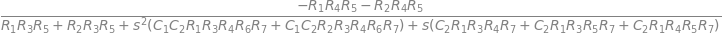

In [9]:
H_sym_lp = cancel(U_sym[v2]/V1,s)
H_sym_lp

In [10]:
sym_num, sym_denom = fraction(H_sym_lp,s) #returns numerator and denominator

In [11]:
sym_num

### Characteristic equation

In [12]:
sym_denom

Get the coefficients of the Laplace variable, s, from the [quadratic equation](https://en.wikipedia.org/wiki/Quadratic_equation):

$as^{2}+bs+c=0$



In [13]:
a = sym_denom.coeff(s**2)
a

In [14]:
b = sym_denom.coeff(s)
b

To find the c coefficient just subract off $bs$ and $cs^2$ from the quadratic equation.

In [15]:
c = sym_denom - b*s - a*s**2
c

## Natural frequency and Q factor
The expressions for the [natural frequency](https://en.wikipedia.org/wiki/Natural_frequency) and [Q factor](https://en.wikipedia.org/wiki/Q_factor) are shown below:

$\omega _n = \sqrt {\frac {c}{a}}$

$Q = \omega _n \frac {a}{b}$

These xpressions have their orgin in classical mechanics describing [harmonic oscillators](https://en.wikipedia.org/wiki/Harmonic_oscillator) and are applicable to 2nd order electrical systems. 

The [damping ratio](https://en.wikipedia.org/wiki/Damping) is defined by the equation:  

$\zeta = \frac {1}{2Q}$


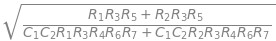

In [16]:
omega_n = sqrt(c/a)
omega_n

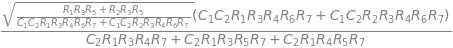

In [17]:
Q = (a/b)*omega_n
Q

Simply the expressions for Q and $\omega _n$ by letting R = R1 = R3 = R4 = R5 = R6 = R7 and C = C1 = C2.

In [18]:
R, C = symbols('R C')

In [19]:
simplify = {
    R1:R,
    R3:R,
    R4:R,
    R5:R,
    R6:R,
    R7:R,
    C1:C,
    C2:C}

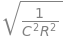

In [20]:
omega_n_simp = omega_n.subs(simplify).factor()
omega_n_simp

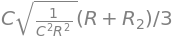

In [21]:
Q_simp = Q.subs(simplify).factor()
Q_simp

By inspection Q could be simplified more, because C cancels out, but we will leave it.

Let C = 0.1$\mu$F, solve for R to get a natural frequency of 1kHz.

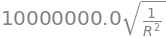

In [22]:
omega_n_simp = omega_n_simp.subs({C:0.1e-6})
omega_n_simp

In [23]:
Rnew = solve(Eq(omega_n_simp,1e3*2*np.pi),R)
Rnew

In [24]:
Rnew = float(Rnew[1])
Rnew

With R and C chosen, 

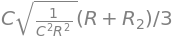

In [25]:
Q_simp

Substituting C=0.1$\mu$F and R = Rnew into Q_simp

In [26]:
Q_simp = Q_simp.subs({C:0.1e-6,R:Rnew})
Q_simp

Solve for R2 for the desired Q=3.

In [27]:
R2new = solve(Eq(Q_simp,3),R2)
R2new = R2new[0]
R2new

The element values are put into the Python dictionary format so that numerical values can be substituted into the equations.


In [28]:
nominal_component_value = {
    V1:1,
    R3:Rnew,
    R6:Rnew,
    R7:Rnew,
    R5:Rnew,
    R2:R2new,
    C1:0.1e-6,
    C2:0.1e-6,
    R1:Rnew,
    R4:Rnew}

In [29]:
Q.subs(nominal_component_value)

In [30]:
omega_n.subs(nominal_component_value)/(2*np.pi)

In [31]:
damping_ratio = 1/(2*Q.subs(nominal_component_value))
damping_ratio

### Numerical solution

In [32]:
# put the element values into the equations
NE = NE_sym.subs(nominal_component_value)

Now we can diplay the network equations with values for the components instead of symbols.

In [33]:
NE

⎡                         I_V1 + 0.000628318530717959⋅v₁ - 0.00062831853071795
⎢                                                                             
⎢            I_O3 - 1.0e-7⋅s⋅v₈ + v₂⋅(1.0e-7⋅s + 0.000628318530717959) - 0.000
⎢                                                                             
⎢   -0.000628318530717959⋅v₁ - 0.000628318530717959⋅v₂ + 0.00188495559215388⋅v
⎢                                                                             
⎢             I_O1 - 0.000628318530717959⋅v₃ + 0.00125663706143592⋅v₄ - 0.0006
⎢                                                                             
⎢                              0.000706858347057704⋅v₅ - 7.8539816339745e-5⋅v₇
⎢                                                                             
⎢               -1.0e-7⋅s⋅v₇ - 0.000628318530717959⋅v₄ + v₆⋅(1.0e-7⋅s + 0.0006
⎢                                                                             
⎢I_O2 - 1.0e-7⋅s⋅v₆ - 7.8539816339745e-5⋅v₅ + v₇⋅(1.

Using the SymPy solve function we can solve the system of equations.

In [34]:
U = solve(NE,X)

### Low pass filter transfer function

In [35]:
H_lp = U[v2]/U[v1]
H_lp.factor()

The SymPy function, factor(), takes a polynomial and factors it into irreducible factors over the rational numbers. Notice that the value is negative, indicating that the filter configuration is inverting.

#### Convert transfer function to SciPy system
In this section we convert the SymPy equations into Numpy format.  

Extract the numerator and denominator polynomials so that the system can be defined in SciPy.

In [36]:
H_lp_num, H_lp_denom = fraction(H_lp) #returns numerator and denominator

The SciPy function, TransferFunction, represents the system as the continuous-time transfer function and takes as inputs the coeeficients of the numerator and denominator polynominals.

In [37]:
# convert symbolic to numpy polynomial
lp_a = np.array(Poly(H_lp_num, s).all_coeffs(), dtype=float)
lp_b = np.array(Poly(H_lp_denom, s).all_coeffs(), dtype=float)
lp_sys = signal.TransferFunction(lp_a,lp_b)

### High pass filter transfer function

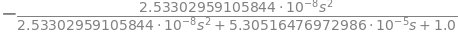

In [38]:
H_hp = U[v4]/U[v1]
H_hp.factor()

In [39]:
H_hp_num, H_hp_denom = fraction(H_hp) #returns numerator and denominator

In [40]:
# convert symbolic to numpy polynomial
hp_a = np.array(Poly(H_hp_num, s).all_coeffs(), dtype=float)
hp_b = np.array(Poly(H_hp_denom, s).all_coeffs(), dtype=float)
hp_sys = signal.TransferFunction(hp_a,hp_b)

### Band pass filter transfer function

In [41]:
H_bp = U[v7]/U[v1]
H_bp.factor()

In [42]:
H_bp_num, H_bp_denom = fraction(H_bp) #returns numerator and denominator

In [43]:
# convert symbolic to numpy polynomial
bp_a = np.array(Poly(H_bp_num, s).all_coeffs(), dtype=float)
bp_b = np.array(Poly(H_bp_denom, s).all_coeffs(), dtype=float)
bp_sys = signal.TransferFunction(bp_a,bp_b)

### Poles and zeros of the low pass transfer function
The poles and zeros of the transfer function can easly be obtained with the following code:

In [44]:
lp_sys_zeros = np.roots(lp_sys.num)
lp_sys_poles = np.roots(lp_sys.den)

#### Low pass filter pole zero plot
The poles and zeros of the preamp transfer function are plotted.

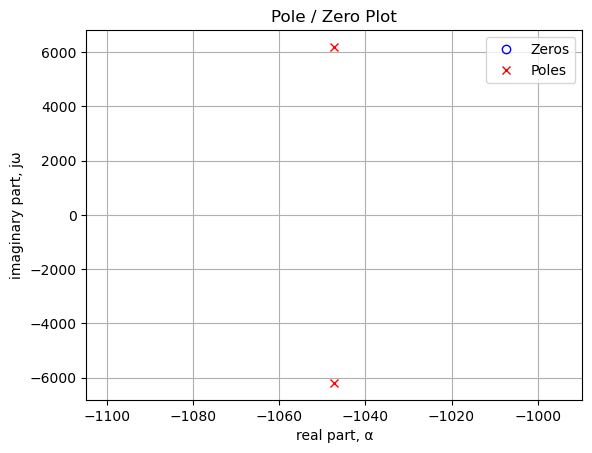

In [45]:
plt.plot(np.real(lp_sys_zeros), np.imag(lp_sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(lp_sys_poles), np.imag(lp_sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=1)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

Poles and zeros of the transfer function plotted on the complex plane. The units are in radian frequency.

Printing these values in Hz.

In [46]:
print('number of zeros: {:d}'.format(len(lp_sys_zeros)))
for i in lp_sys_zeros:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of zeros: 0


In [47]:
print('number of poles: {:d}'.format(len(lp_sys_poles)))
for i in lp_sys_poles:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of poles: 2
-166.67+986.01j Hz
-166.67-986.01j Hz


### Stability
By inspecting the plot above, we can tell the filter is stable since all the poles of the transfer function are in the left hand plane.

### Bode plot
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter. In electrical engineering, a [Bode plot](https://en.wikipedia.org/wiki/Bode_plot) is a graph of the frequency response of a system. It is usually a combination of the magnitude (usually in decibels) of the frequency response and the phase shift. As originally conceived by Hendrik Wade Bode in the 1930s, the plot is an asymptotic approximation of the frequency response, using straight line segments. Bode plots are used to assess the stability of systems by finding the gain and phase margins.

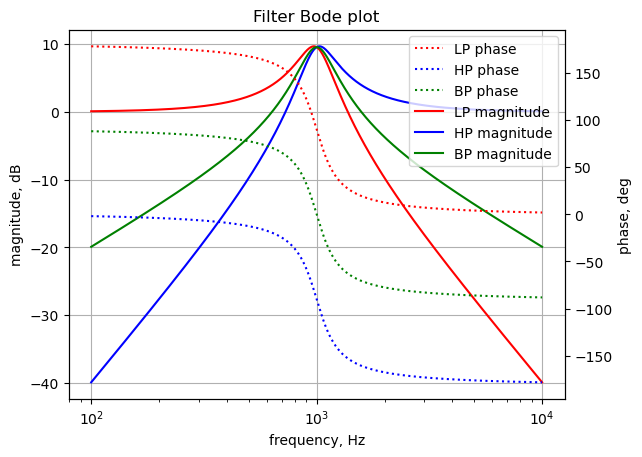

In [48]:
x_axis_range = np.logspace(2, 4, 5000, endpoint=True)*2*np.pi
w, lp_mag, lp_phase = lp_sys.bode(w=x_axis_range)
w, hp_mag, hp_phase = hp_sys.bode(w=x_axis_range)
w, bp_mag, bp_phase = bp_sys.bode(w=x_axis_range)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

# Bode magnitude plot
plt.semilogx(w/(2*np.pi), lp_mag,'-r')
plt.semilogx(w/(2*np.pi), hp_mag,'-b')
plt.semilogx(w/(2*np.pi), bp_mag,'-g')

ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'k' #'tab:blue'

# Bode phase plot
plt.semilogx(w/(2*np.pi), lp_phase,':r',label='LP phase')
plt.semilogx(w/(2*np.pi), hp_phase,':b',label='HP phase')
plt.semilogx(w/(2*np.pi), bp_phase,':g',label='BP phase')

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(np.NaN, np.NaN, '-', color='r', label='LP magnitude')
ax2.plot(np.NaN, np.NaN, '-', color='b', label='HP magnitude')
ax2.plot(np.NaN, np.NaN, '-', color='g', label='BP magnitude')

plt.legend(loc=0)
plt.title('Filter Bode plot')
plt.show()

The Bode plot for the preamplifier is plotted from 100 Hz to 1 kHz.

### Low pass filter impulse and step response
Use the SciPy functions [impulse](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse.html) and [step](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step.html) to plot the impulse and step response of the system.

The [impulse](https://en.wikipedia.org/wiki/Impulse_response) and [step response](https://en.wikipedia.org/wiki/Step_response) of the filter are plotted below. Any linear, time-invariant is completely characterized by its impulse response. The transfer function is the Laplace transform of the impulse response. The impulse response defines the response of a linear time-invariant system for all frequencies.

In electronic engineering and control theory, step response is the time behavior of the outputs of a general system when its inputs change from zero to one in a very short time.

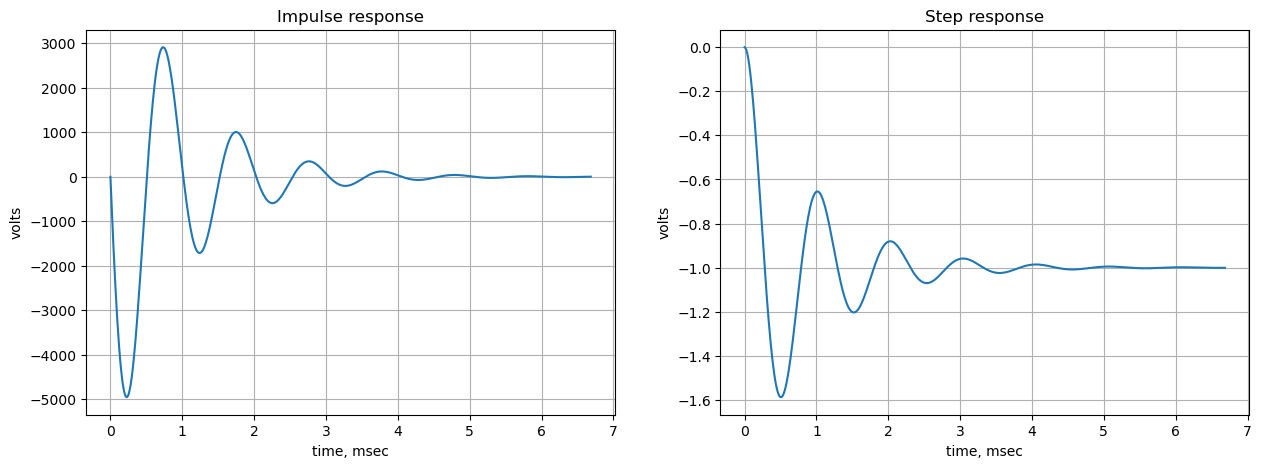

In [49]:
plt.subplots(1,2,figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse(lp_sys,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step(lp_sys,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# show plot
plt.show()

### Low pass filter group delay
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

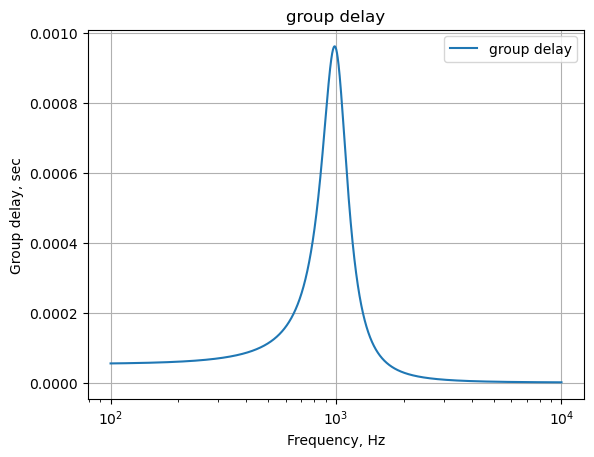

In [51]:
plt.title('group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(lp_phase*np.pi/180)/np.gradient(w),'-',label='group delay')

plt.ylabel('Group delay, sec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid()
plt.show()

## Summary
A state variable filter was analized. Component values for a filter of Q=3 and natural frequency of 1kHz were derived. Various typical filter performance plots were generated.